# Решение ОДУ

Подмодуль [scipy.integrate](https://docs.scipy.org/doc/scipy/reference/integrate.html#module-scipy.integrate) содержит в себе множество методов решения систем обыкновенных дифференциальных уравнений (ОДУ, `ordinary differential equation`, `ODE`).

Т.к. везде ниже будут строиться графики полученного и точного решений уравнения, определим функцию для построения графиков этих решений.

In [1]:
from matplotlib import pyplot as plt
def plot(ax, x, exact_sol, sol_x, sol_y, xlabel="t", s="r."):
    ax.plot(x, exact_sol(x), "b")
    ax.plot(sol_x, sol_y, s)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("y")
    ax.legend(["Точное решение", "Приближенное решение"])


## Задача Коши

Функция [scipy.integrate.solve_ivp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) (`solve initial value problem`) позволяет численно решать задачу Коши вида

$$
\begin{cases}
\dfrac{dy}{dt} = f(t, y) \\
y(t_0) = y_0.
\end{cases}
$$

Предполагается, что в общем случае $y=y(t)$ является векторной и решается система обыкновенных дифференциальных уравнений.

$$
\begin{cases}
\dot{y}_1 = f_1(t, y_1, \cdots, y_n), \\
\cdots \\
\dot{y}_n = f_n(t, y_1, \cdots, y_n), \\
y_1(t_0) = y_{10}, \\
\cdots \\
y_n(t_0) = y_{n0}.
\end{cases}
$$

```{note}
Чтобы численно решить уравнение $n$-го порядка, необходимо свести его к системе из $n$ уравнений первого порядка.
```

В качестве самого простого примера, решим уравнение

$$
\begin{cases}
y' = y, \\
y(0) = 0.
\end{cases}
$$

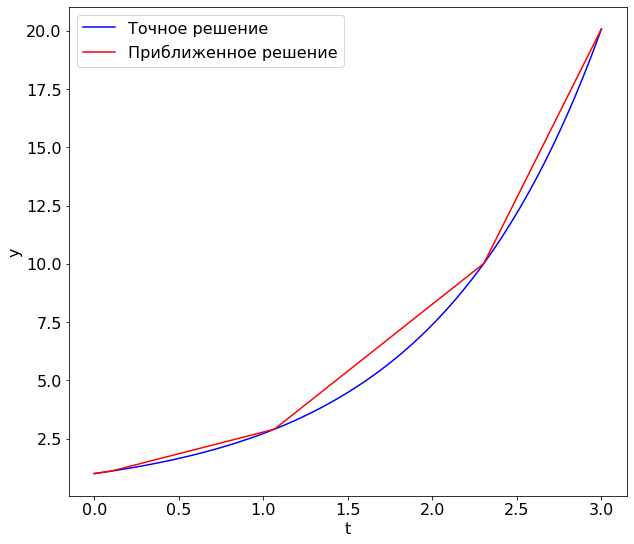

In [58]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt


def f(t, y):
    return y

def exact_solution(t):
    return np.exp(t)

y_0 = [1]
t_0 = 0
t_final = 3
sol = integrate.solve_ivp(f, (t_0, t_final), y_0)


fig, ax = plt.subplots()
fig.set_size_inches((10, 9))
plot(ax, np.linspace(t_0, t_final, 100), exact_solution, sol.t, sol.y[0], s="r-")

На что следует обратить внимание.
- Хоть правая часть уравнения и не зависит явным образом от $t$, функция `f(t, x)` все равно объявляется с первым параметром `t`;
- Функция $y=y(t)$ в этом уравнение скалярная, но мы представляем её в виде векторной функции $f:\mathbb{R}^1 \to \mathbb{R}^1$;
- Помимо функции правой части искомого ОДУ, функция `scipy.integrate.solve_ivp` принимает отрезок `t_span` ($[t_0, t_{\text{final}}])$, на котором решается уравнение, и начальные условия в виде вектора $y_0$;
- В итоговом решение компонента `sol.t` соответствует значениям по оси `t`, а `sol.y` значениям полученного решения в точках из `sol.t`. Т.к. $y$ считается векторной функцией, то `sol.е` --- матрица, каждая строка которой соответствует компоненте вектора $y$, а каждый столбец значению $t$ из `sol.t`; 
- Для данного уравнения функция `scipy.integrate.solve_ivp` выдала решение, содержащее совсем небольшое количество значений $t$. Можно попросить у этой функции получить решение на заданной сетке $t$.

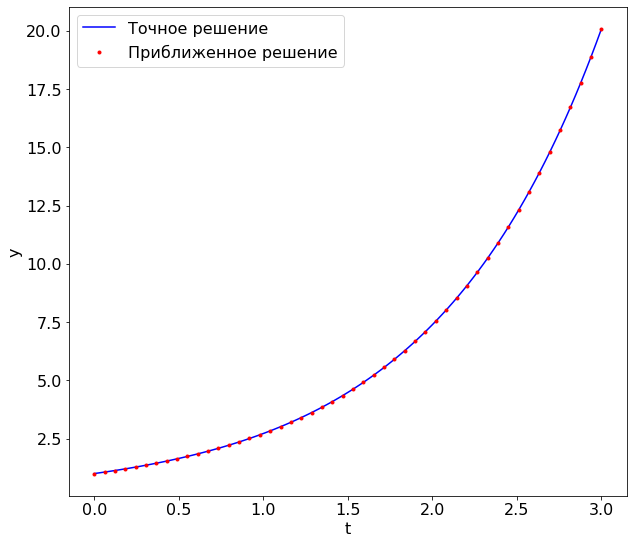

In [59]:
sol = integrate.solve_ivp(f, (t_0, t_final), y_0, t_eval=np.linspace(t_0, t_final, 50))

fig, ax = plt.subplots()
fig.set_size_inches((10, 9))
plot(ax, np.linspace(t_0, t_final, 100), exact_solution, sol.t, sol.y[0])

## Выбор метода решения ОДУ

Решение таких систем ОДУ отнюдь не тривиально. Разработано множество методов их решения и ряд из них "зашит" в подмодуле `scipy.integrate`, среди которых:
- Явные [ме́тоды Ру́нге — Ку́тты](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%A0%D1%83%D0%BD%D0%B3%D0%B5_%E2%80%94_%D0%9A%D1%83%D1%82%D1%82%D1%8B) 2-го (`RK23`), 4-го (`RK45`) и 8-го (`DOP853`) порядков;
- Неявный метод Руне --- Кутты 5-го порядка `Radau`;
- Неявные методы [BDF](https://en.wikipedia.org/wiki/Backward_differentiation_formula) и `LSODA`.

Основным критерием выбора является [жесткость системы ОДУ](https://ru.wikipedia.org/wiki/%D0%96%D1%91%D1%81%D1%82%D0%BA%D0%B0%D1%8F_%D1%81%D0%B8%D1%81%D1%82%D0%B5%D0%BC%D0%B0): явные методы плохо проявляют себя на жестких системах. `SciPy` рекомендует использовать по умолчанию метод `RK45` и если он плохо/долго сходится переключаться на метод `Radau` иди `BDF`. 

## Краевая задача

Функция [scipy.integrate.solve_bvp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html#scipy.integrate.solve_bvp) (`Solve boundary value problem`) предназначена для решения системы ОДУ с краевыми условиями

$$
\begin{cases}
\dfrac{dy}{dx} = f(x, y) \\
y(a) = y_a \\
y(b) = y_b.
\end{cases}
$$

В качестве аргументов функция `solve_bvp` принимает: 
- функцию `f`, задающую правую часть уравнения,
- функцию `bc` (сокращение от `boundary condition`), задающую невязку для граничных условий,
- массив `x`, определяющий сетку значений независимой переменной $x$, 
- массив `y`, задающий "догадку" об итоговом решении $y = y(x)$.

В качестве примера решим уравнение

$$
\begin{cases}
y'' + y = 0 \\
y(0) = 1 \\
y(\frac{\pi}{2}) = 0,
\end{cases}
$$

на отрезке $x \in [0, \frac{\pi}{2}]$. Чтобы это сделать, необходимо свести это уравнение второго порядка к системе уравнений первого порядка. Для этого введем обозначения $z_1 = y$ и $z_2 = y'$. Тогда систему выше можно записать в виде

$$
\begin{cases}
z_1' = z_2 \\
z_2' = - z_1 \\
z_1(0) = 1 \\
z_1(\frac{\pi}{2}) = 0.
\end{cases}
$$


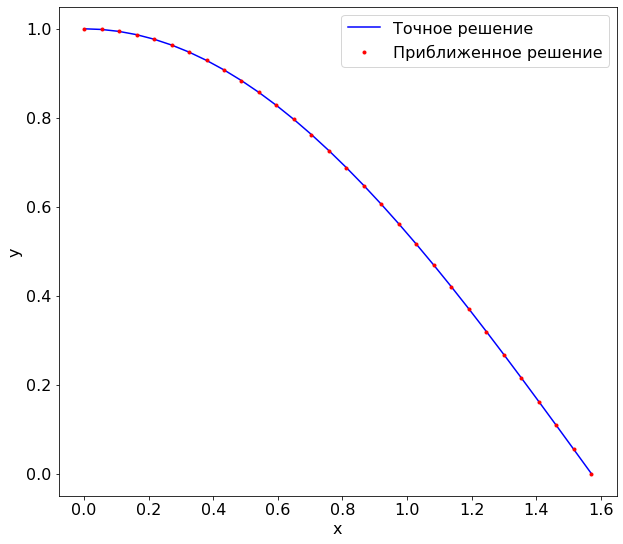

In [60]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt


def f(x, z):
    return [
        z[1],
        -z[0]
    ]

def R(za, zb):
    return np.array([za[0] - 1, zb[0]]) 

def exact_solution(x):
    return np.cos(x)

a, b = 0, np.pi/2
N = 30
x = np.linspace(a, b, N)
z_guess = np.zeros((2, N), dtype=float)

sol = integrate.solve_bvp(f, R, x, z_guess)

fig, ax = plt.subplots()
fig.set_size_inches((10, 9))
plot(ax, x, exact_solution, sol.x, sol.y[0], xlabel="x")